In [1]:
## Scrape player data if we haven't already
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import OutputType
import pandas as pd
from os import path
from datetime import datetime

# Get last advanced season statistics for all players
year = str(datetime.now().year)

ADVANCED_SEASON_TOTALS = f"data/player_advanced_stats_{year}.csv"
SEASON_TOTALS = f"data/player_stats_{year}.csv"
MERGED_DATASET_FILE = f"data/player_combined_data_{year}.csv"
OUTPUT_FILE = f"output_files/players_ranked_by_score_{year}.csv"

if not path.exists(MERGED_DATASET_FILE):
    print("Scraping advanced and regular season totals.")
    client.players_advanced_season_totals(season_end_year=2020,
        output_type=OutputType.CSV, output_file_path=ADVANCED_SEASON_TOTALS)
    client.players_season_totals(season_end_year=2020,
        output_type=OutputType.CSV, output_file_path=SEASON_TOTALS)

    with open(ADVANCED_SEASON_TOTALS) as advanced:
        with open(SEASON_TOTALS) as regular:
            newdata = open(MERGED_DATASET, 'w+')
            i = 0
            reglines = regular.readlines()
            for line in advanced.readlines():
                    newdata.write(line.replace('\n','') + reglines[i])
                    i += 1
    print("Datasets merged.")
else:
    print("Dataset found.")

Dataset found.


In [2]:
import json, sys

## Define player structure
class Player:
    def __init__(self, score, name, position):
        self.score = score
        self.name = name
        self.pos = position
    def __lt__(self, other):
        return self.score < other.score

In [3]:
## Define strategy paramaters and their weightings 
strategy_name = "config/strategy.json"
config = json.load(open(strategy_name) )
print("Found configuration:", json.dumps(config, indent=4, sort_keys=True))
  
choice = input("Enter Y to accept or enter a new config: ")
if not choice=="Y":
    config = json.loads(choice)
    
print("\nConfiguration is: ", json.dumps(config, indent=4, sort_keys=True))

Found configuration: {
    "player_stat_categories": {
        "assists": 2,
        "blocks": 0.05,
        "defensive_rebounds": 1,
        "games_played": 3,
        "games_started": 3,
        "made_field_goals": 2,
        "made_free_throws": 0.05,
        "made_three_point_field_goals": 2,
        "minutes_played": 0.01,
        "offensive_rebounds": 1,
        "steals": 0.05,
        "total_rebound_percentage": 0.05,
        "true_shooting_percentage": 0.05,
        "turnovers": -2
    }
}
Enter Y to accept or enter a new config: Y

Configuration is:  {
    "player_stat_categories": {
        "assists": 2,
        "blocks": 0.05,
        "defensive_rebounds": 1,
        "games_played": 3,
        "games_started": 3,
        "made_field_goals": 2,
        "made_free_throws": 0.05,
        "made_three_point_field_goals": 2,
        "minutes_played": 0.01,
        "offensive_rebounds": 1,
        "steals": 0.05,
        "total_rebound_percentage": 0.05,
        "true_shooting_perce

In [4]:
## Generate a score for each player.

with open(MERGED_DATASET_FILE) as data:
    # get indices of each CSV category
    tokens = {}
    i = 0
    for token in data.readlines()[0].split(','):
        tokens[token.replace('\n', '')] = i
        i+= 1

    data.seek(0)
    results = []
    observed_min, observed_max = sys.maxsize, -sys.maxsize
    for line in data.readlines()[1:]:
        line = line.split(',')
        score = 0
        for category in config["player_stat_categories"].keys():
            score_this_category = float(line[tokens[category]]) * config["player_stat_categories"][category]
            score += score_this_category
        observed_min = observed_min if observed_min < score else score
        observed_max = observed_max if observed_max > score else score
        name = line[tokens["name"]]
        positions = line[tokens["positions"]]
        results.append(Player(score, name, positions))

    results.sort(reverse=True)

In [5]:
## Scale to score between 0 -> 100%
for i in range(len(results)):
    results[i].score /= observed_max
    results[i].score = round(results[i].score * 100, 2)

Text(0.5, 1.0, 'Distribution of Player Scores')

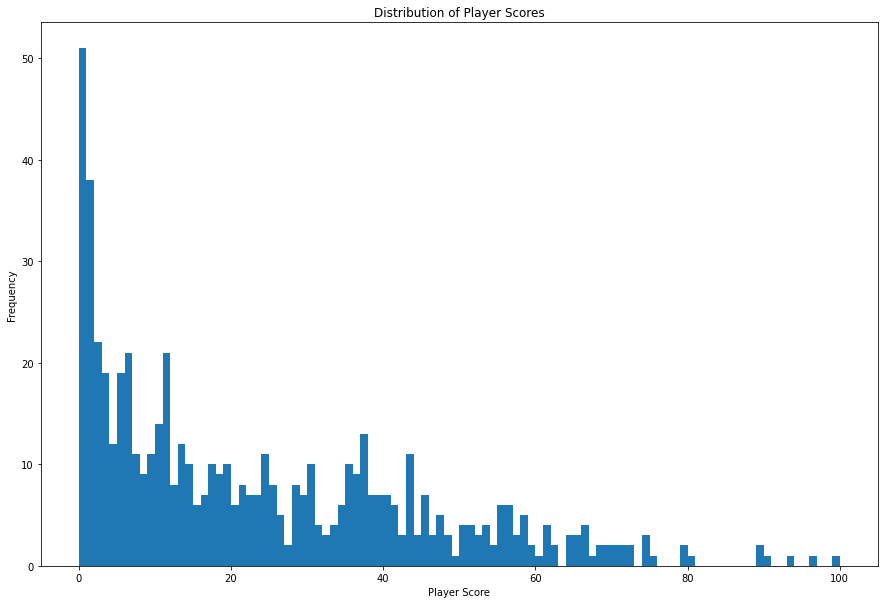

In [6]:
## Plot the player scores to make sure this makes sense.
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
matplotlib.rcParams['figure.figsize'] = [15, 10]

x = [y.score for y in results]
plt.hist(x, density=False, bins=100) 
plt.ylabel('Frequency')
plt.xlabel('Player Score');
plt.title('Distribution of Player Scores')

In [7]:
## Configure number of players required in each positions
required_players = {
    "C": {
        "number": 1,
        "positions": ["CENTER"]
    },
    "F": {
        "number": 2,
        "positions": ["SMALL FORWARD", "POWER FORWARD"]
    },
    "G": {
        "number": 2,
        "positions": ["POINT GUARD", "SHOOTING GUARD"]
    },
    "ANY": {
        "number": 3
    }
}

drafted = {
    "C": 0,
    "F": 0,
    "G": 0,
    "ANY": 0
}
should_draft = []

In [8]:
## Run the draft. Ask for the name of the drafted player
from IPython.display import display, Markdown, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
buttons = widgets.ToggleButtons(
    options=['My Pick', 'Others Pick'],
    description="Who's pick?",
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
#     icons=['check'] * 3
)
text = widgets.Text(
    value='',
    placeholder='',
    description='Picked:',
    disabled=False
)

textArea = widgets.Textarea(
    value='',
    placeholder='',
    description='Should pick:',
    disabled=False
)

In [9]:
from IPython.display import clear_output
def update_round(b):
    clear_output()
    display(buttons)
    display(text)
    button = widgets.Button(description="Submit Round")
    display(button)
    button.on_click(update_round)
    if buttons.value == "My Pick":
        # Start from top of the results list, pick a position we need to fill.
        for i in range(len(results)):
            position = results[i].pos
            if "CENTER" in position:
                letter = "C"
            elif "FORWARD" in position:
                letter = "F"
            elif "GUARD" in position:
                letter = "G"

            num_needed = required_players[letter]["number"] + required_players["ANY"]["number"]
            num_have = drafted[letter] + drafted["ANY"]


            if num_have < num_needed:
                if drafted[letter] < required_players[letter]["number"]:
                    drafted[letter] += 1
                else:
                    drafted["ANY"] += 1
                    
                print("You should pick", results[i].name)
                should_draft.append(results[i].name)
                print("Current team:", should_draft, drafted)
                results.pop(i)
                return
        print("Team full: ", should_draft, drafted)
    else:
        picked = text.value
        # Remove player from set of available
        for i in range(len(results)):
            if (results[i].name.find(picked) == 0):
                
                print("Removed ", results[i].name)
                results.pop(i)
                
                return

In [10]:
display(buttons)
display(text)
button = widgets.Button(description="Submit Round")
display(button)
button.on_click(update_round)

ToggleButtons(description="Who's pick?", options=('My Pick', 'Others Pick'), tooltips=('Description of slow', …

Text(value='', description='Picked:', placeholder='')

Button(description='Submit Round', style=ButtonStyle())

You should pick LeBron James
Current team: ['LeBron James'] {'C': 0, 'F': 0, 'G': 1, 'ANY': 0}
